# Objetivo.

Determinar computacionalmente que distribucion siguen el TPA para dos formas de calcularlo para la tecnica f-scan.

1. Método de función inversa.
2. Método de regresion.


In [12]:
# LIBRERIAS
import matplotlib
from ipywidgets.widgets.widget_string import Label
import numpy as np
from scipy.stats import norm
import matplotlib.pylab as plt
from scipy import stats
import pandas as pd

%matplotlib inline 
#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20) 
font = {'weight' : 'bold',
        'size'   : 10}
matplotlib.rc('font', **font)
import seaborn as sns
import os
from scipy.stats import anderson
from scipy.stats import kstest
from scipy.stats import shapiro 
#to en otra carpeta
sns.set_theme()

# Funciones base utilizadas a lo largo del codigo:



In [13]:
# Función ajustar
def fscanTH2(z,focal,beta,L,Pavg,Tp,wl,D,Cf,alfa,R,freq):

    Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
    z0 = np.pi*w0**2/wl # Rayleigh range
    w = w0*np.sqrt(1 + (z/z0)**2) # Beam radius
    I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
    B = beta*(1.0 - R)*I0*Leff
    # Transmitance
    T=1-1/(2*np.sqrt(2))*beta*(1-R)*I0*Leff/(1+(z/z0)**2)
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return T

# Función ajustar
def BETA(trans,z,focal,L,Pavg,Tp,wl,D,Cf,alfa,R,freq):

    Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
    z0 = np.pi*w0**2/wl # Rayleigh range
    w = w0*np.sqrt(1 + (z/z0)**2) # Beam radius
    I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample 
    # Transmitance
    b=(1-trans)*(1/(2*np.sqrt(2))*(1-R)*I0*Leff/(1+(z/z0)**2))**-1
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return b


def ruido(señal,desv): 
    '''
    Función para añadir ruido Gaussiano dada una desviación estandar

    Parametros
    ----------
    señal: Arreglo
      Arreglo con la señal a la que se le va añadir el ruido
    desv: float
      Desviación estandar
    '''
    señal_ruido=[np.random.normal(señal[i], abs(señal[i]*desv)) for i in range(0,len(señal))]
    return np.array(señal_ruido)

def central(s,k):

    '''
    Funcion para verificar teorema del limite central

    Parametros
    -----------
    s: Arreglo
     Arreglo de datos a los que se quieren aplicar el teorema
    k: float
     Numero de datos para efectuar el promedio

'''

    new_s=[]

    for i in range(0,len(s)):
        new_s.append(np.mean(np.random.choice(s,size=k)))
    return new_s

def confirm_gauss(s):
    result = (anderson(np.sort(s), dist='norm'))
    criterio=((result[0]<result[1][3])or(shapiro(np.sort(s))[1]>0.05))*1   
    return criterio
    


# Datos que se asumen como reales:

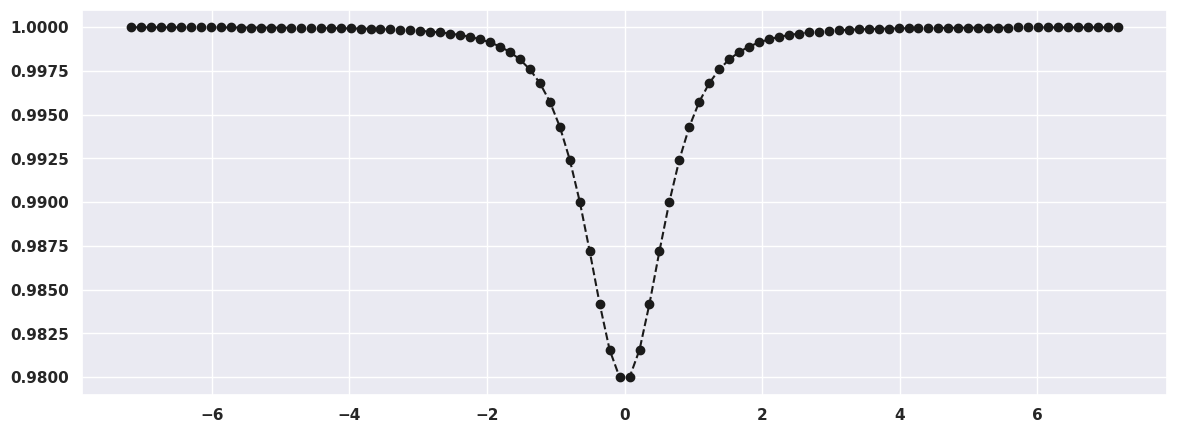

In [3]:
fig=plt.figure(figsize=(14,5))
######################## PARAMETROS QUE SE ASUMEN COMO LOS REALES
beta = 3.4e-11 # TPA seed in (m/W )
L= 1e-3 # thickness in (m).
Pavg = 200e-3# Average power in (W)
Tp =  200e-15 # pulse width FWHM in (s)
wl =790e-9 #central wavelength in (m)
D = 2e-3 # beam diameter in (m)
focal =15e-2 # Distance EFTL-sample (m)a
Cf = 1.36 # beam correction coeff
alfa = 2.64e-1 # linear absorption in (1/m) 
R =0.33 # reflection percentage 
freq = 90.6e6#Frecuencia en HZ
w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
z0 = np.pi*w0**2/wl # Rayleigh range
z=np.linspace(-1/2*focal,1/2*focal,100)#focal distance [m]
T=list(fscanTH2(z,focal,beta,L,Pavg,Tp,wl,D,Cf,alfa,R,freq)) #Señal simulada
val_min=min(T)
index=T.index(min(T))
plt.plot(z/z0,T,'--ko',label='simulated signal')
#plt.plot(corriente,Td,'--ro',label='derivada')

En este notebook se estudia de forma sistematica, el ajuste del fenomeno de absorción de dos fotones bajo las dos perspectivas presentadas en el articulo.


# 1) Perspectiva 1.
En esta perspectiva se cuenta con la siguiente ecuación que da el parametro físico de interes:

$$\beta=\left[\frac{1}{2\sqrt{2}} \frac{(1-R) I_0(f)L_{eff}}{1+\left(\frac{z}{z_0(f)}\right)^{2}} \right]^{-1}\left[1-T(f,β;\{L, P_{av}, T_{p}, w_{l}, D, ds, C_f, \alpha, R\})\right] \hspace{2 mm} (1)$$

A continuación fijamos los parametros del experimento que asumiremos como reales:

In [4]:
def dist_betas(N,desv,k,par): 
    '''
    Parametros
    ----------
    N: float
        Numero de valores con los que se va a formar el histograma
    desv: float
        Arreglo con distancias focales utilizadas.
    k: float
        indice del arreglo de la distancia focal.
    par: array
        arreglo de 0 o 1 dependiendo de cual parametro se quiera investigar.
        [L,P,T,wl,D,focal,Cf,alpha,R,freq,trans,z]

    La función devuelve la distribucion de beta
    '''
  # Cont,edra valores de TPA
    TPA=[]
    TT=list(fscanTH2(z,focal,beta,L,Pavg,Tp,wl,D,Cf,alfa,R,freq)) #Señal simulada
    trans=TT[k] #Minimo de la señal simulada.  
    er=desv/(1.96*100)
    er_L=er*par[0]
    er_P=er*par[1]
    er_T=er*par[2]
    er_wl=er*par[3]
    er_D=er*par[4]
    er_focal=er*par[5]
    er_Cf=er*par[6]
    er_a=er*par[7]
    er_R=er*par[8]
    er_freq=er*par[9]
    er_trans=er*par[10]
    er_z=er*par[11]


    for ii in range(N):


        L_f = np.random.normal(L,L*er_L,1) # # thickness in (m).
        Pavg_f = np.random.normal(Pavg,Pavg*er_P,1) # Average power in (W)
        Tp_f = abs(np.random.normal(Tp,Tp*er_T,1)) # Pulse width FWHM in (s). sech
        wl_f = np.random.normal(wl,wl*er_wl,1) #central wavelength in (m)
        D_f = np.random.normal(D,D*er_D,1) # beam diameter in (m)
        z_f = np.random.normal(z[k],abs(z[k])*er_z,1) # EFTL-sample distance (m)
        Cf_f = np.random.normal(Cf,Cf*er_Cf,1) # Beam correction factor
        alfa_f =  abs(np.random.normal(alfa,alfa*er_a,1)) #linear absorption (1/m)
        R_f = np.random.normal(R,R*er_R,1) # Reflectance
        freq_f = np.random.normal(freq,freq*er_freq,1) # Reflectance
        trans_f= np.random.normal(trans,abs(trans)*er_trans,1)
        focal_f=np.random.normal(focal,focal*er_focal,1) 
        
        TPA.append(BETA(trans_f,z_f,focal_f,L_f,Pavg_f,Tp_f,wl_f,D_f,Cf_f,alfa_f,R_f,freq_f)[0]*1e11)
      
    
    return TPA

# Ejemplo:

Como ejemplo ilustrativo de lo que se hara luego, se considera la distribución de betas de acuerdo a la función previamente definida para un error relativo dado. Se confirma si la distribución obtenida sigue o no una distribución gaussiana. Además se le aplica el teorema del limite central.

Criterio de gaussianidad:  1


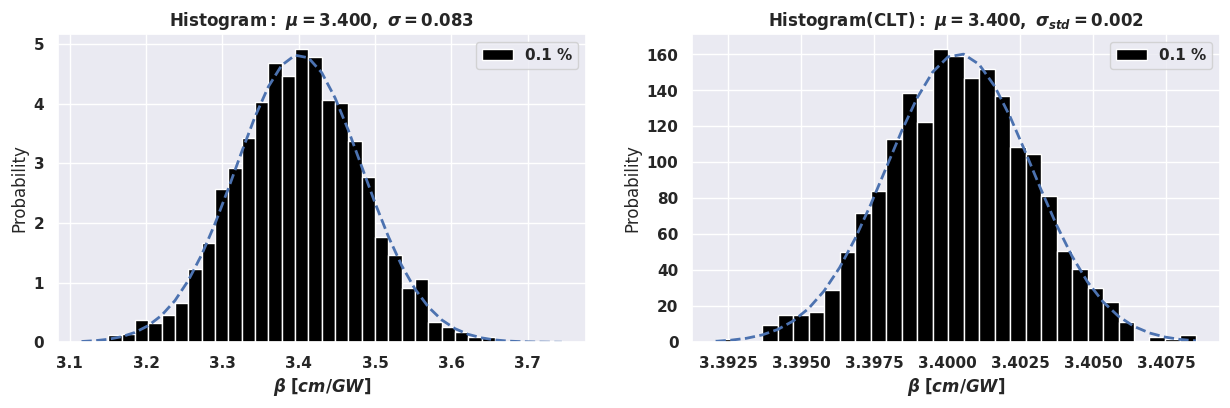

In [5]:
f=plt.figure(figsize=(15,4))

params=np.ones(12)
plt.subplot(121)
er_r=0.1
beta_hist=np.array(dist_betas(2000,er_r,index,params))
print('Criterio de gaussianidad: ',confirm_gauss(beta_hist))
(mu, sigma) = norm.fit(beta_hist)
n, bins, patches =plt.hist(beta_hist,bins='fd',density=True,color='black',label=str(er_r)+' %')
y = norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'b--', linewidth=2)
plt.ylabel('Probability')
plt.xlabel(r'$\beta$ $[cm/GW]$')
plt.title(r'$\mathrm{Histogram:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)
plt.legend()


plt.subplot(122)

beta_hist=central(beta_hist,1000)
error=(round(np.std(beta_hist,ddof=1)/np.sqrt(len(beta_hist)),1))
(mu, sigma) = norm.fit(beta_hist)
n, bins, patches =plt.hist(beta_hist,bins='fd',density=True,color='black',label=str(er_r)+' %')

# add a 'best fit' line
y = norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'b--', linewidth=2)
plt.ylabel('Probability')
plt.xlabel(r'$\beta$ $[cm/GW]$')
plt.title(r'$\mathrm{Histogram(CLT):}\ \mu=%.3f,\ \sigma_{std}=%.3f$' %(mu, sigma))
plt.grid(True)
plt.legend()


Nuestro proposito a continuación es verificar en general para que valores de error la distribución de betas sigue una distribucion gaussiana. En general existen diferentes valores de corriente que se pueden seleccionar para realizar el calculo de beta y por tanto obtener una distribucion. Por tanto, se deben verificar todos los valores dentro del rango ya definido (0,300) mA.

# Variación todos los parametros.

In [6]:
beta_med=[]
beta_sig=[]
er_r=np.linspace(0.005,10,50) #Porcentaje de error
final=np.zeros((len(er_r),len(z)))

for k in range(len(z)):

    for c,j in enumerate(er_r):

        beta_hist=np.array(dist_betas(500,j,k,params))
        criterio=confirm_gauss(beta_hist)
        final[c,k]=criterio
        

([<matplotlib.axis.YTick at 0x7f01205ac5b0>,
 [Text(0, 0, '0.0'),
  Text(0, 8, '1.64'),
  Text(0, 16, '3.27'),
  Text(0, 24, '4.9'),
  Text(0, 32, '6.53'),
  Text(0, 40, '8.16'),
  Text(0, 48, '9.8')])

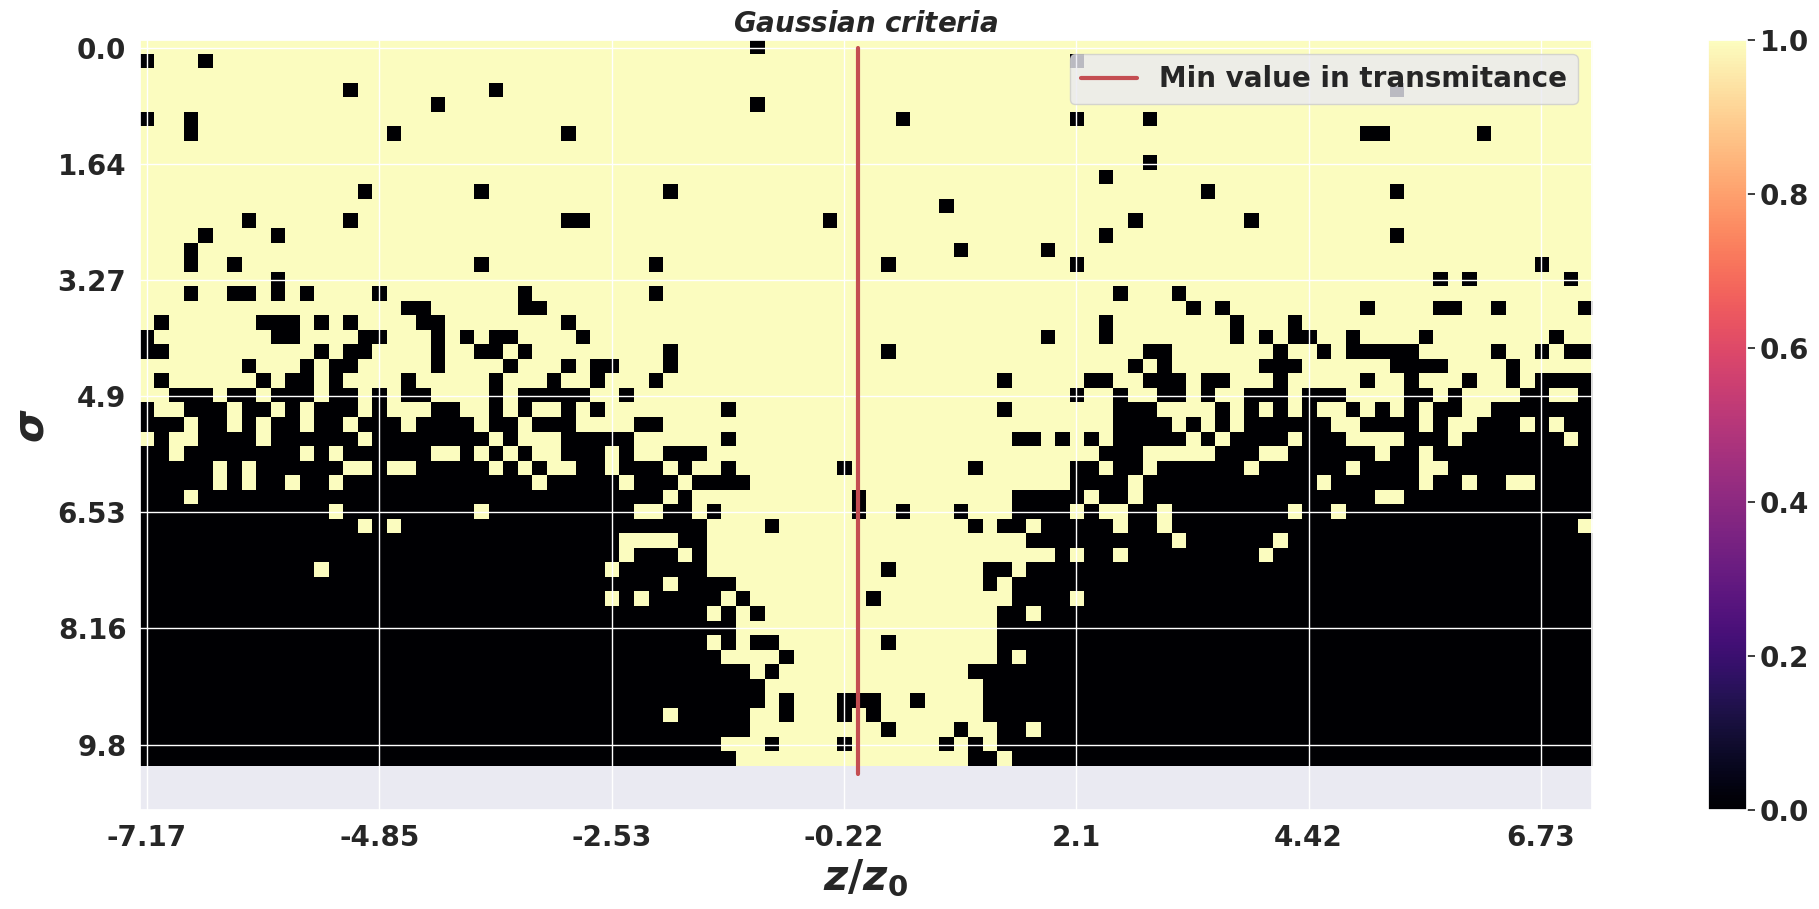

In [9]:
fig = plt.figure(figsize=(30,10))

er_r=np.linspace(0.005,10,50) #Porcentaje de error
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
plt.imshow(final, cmap='magma')
plt.plot([index,index],[len(er_r),0],'r',lw=3,label='Min value in transmitance')
plt.ylabel('$\sigma$ ',fontsize=30)
plt.xlabel('$z/z_0$',fontsize=30)
plt.title('$Gaussian$ $criteria$',fontsize=20)
plt.legend(fontsize=20)
plt.colorbar()

nx = z.shape[0]
no_labels = 7 # how many labels to see on axis x
step_x = int(nx / (no_labels - 1)) # step between consecutive labels
x_positions = np.arange(0,nx,step_x) # pixel count at label position
x_labels = np.round((z/z0)[::step_x],2) # labels you want to see
plt.xticks(x_positions, np.sort(x_labels),fontsize=20)

ny = er_r.shape[0]
no_labels = 7 # how many labels to see on axis x
step_y = int(ny / (no_labels - 1)) # step between consecutive labels
y_positions = np.arange(0,ny,step_y) # pixel count at label position
y_labels = np.round(er_r[::step_y],2) # labels you want to see
plt.yticks(y_positions, np.sort(y_labels),fontsize=20)


El grafico anterior muestra que en general la distribución de betas no sera Gaussiana. Sin embargo, para errores pequeños, en las cercanias del valor de distancia focal que corresponde al minimo de transmitancia, se puede decir que la distribución de betas es Gaussiana.

# Variacion en un solo parametro.



In [11]:
results=[]
er_r=np.linspace(0.005,10,50) #Porcentaje de error
params=np.diag(np.ones(12))

for i in range(0,12):


    final=np.zeros((len(er_r),len(z)))

    for k in range(len(z)):

        for c,j in enumerate(er_r):

            beta_hist=np.array(dist_betas(500,j,k,params[i,:]))
            criterio=confirm_gauss(beta_hist)
            final[c,k]=criterio
    
    results.append(final)


/usr/lib/python3/dist-packages/scipy/stats/_morestats.py:1758: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/usr/lib/python3/dist-packages/scipy/stats/_morestats.py:1864: RuntimeWarning: invalid value encountered in divide
  w = (y - xbar) / s


In [10]:
f=plt.figure(figsize=(22,40))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
titles=[r'$L$',r'$P_{avg}$',r'$\tau$',r'$\lambda$',r'$D$',r'$f$',r'$C_{f}$',r'$\alpha$',r'$R$',r'$\nu$',r'$T$',r'$z$']
iters=1

for c,i in enumerate(results):

    plt.subplot(6,2,iters)

    matplotlib.rc('xtick', labelsize=20) 
    matplotlib.rc('ytick', labelsize=20) 
    plt.imshow(i, cmap='magma')
    plt.plot([index,index],[len(er_r),0],'r',lw=3,label='Min value in transmitance')
    plt.ylabel('$\sigma$',fontsize=30)
    plt.xlabel('$z/z0$',fontsize=20)
    plt.title(r'Gaussian criteria: Error variation of '+titles[c],fontsize=20)
    plt.legend(fontsize=20)
 

    nx = (z/z0).shape[0]
    no_labels = 7 # how many labels to see on axis x
    step_x = int(nx / (no_labels - 1)) # step between consecutive labels
    x_positions = np.arange(0,nx,step_x) # pixel count at label position
    x_labels = np.round( (z/z0)[::step_x],3) # labels you want to see
    plt.xticks(x_positions, np.sort(x_labels),fontsize=20)

    ny = er_r.shape[0]
    no_labels = 7 # how many labels to see on axis x
    step_y = int(ny / (no_labels - 1)) # step between consecutive labels
    y_positions = np.arange(0,ny,step_y) # pixel count at label position
    y_labels = np.round(er_r[::step_y],3) # labels you want to see
    plt.yticks(y_positions, np.sort(y_labels),fontsize=20)

    iters+=1

    

NameError: name 'results' is not defined

<Figure size 2200x4000 with 0 Axes>

Se debe resaltar algo importante de lo anterior: este resultado fue obtenido simulando los parametros con generadores de números aleatorios gaussianos con media en el valor real. Sin embargo, esto no es conveniente, ya que en una situación real nuestra media de los parametros que medimos no coincide con el valor real del parametro físico. Por tanto a continuación se realizara el mismo grafico añadiendo un error del 1% a las medias de las distribuciones.

# Perspectiva 2.

El método de obtención del parametro físico es hecho mediante una regresión a la ecuación:

$$T(f,β;\{L, P_{av}, T_{p}, w_{l}, D, ds, C_f, \alpha, R\})=1-\frac{1}{2\sqrt{2}} \frac{\beta (1-R) I_0(f)L_{eff}}{1+\left(\frac{d_s-f}{z_0(f)}\right)^{2}} \hspace{2 mm} (2)$$

De la teoria se tiene que $g(x,\beta;\{v_i\})=\beta r(x;\{v_i\})+h(x;\{v_i\})$, en nuestro caso $$h(x;\{v_i\})=1$$ 
$$ r(x;\{v_i\})=-\frac{1}{2\sqrt{2}} \frac{(1-R) I_0(f)L_{eff}}{1+\left(\frac{d_s-f}{z_0(f)}\right)^{2}}$$

Por tanto,

$$\beta=\frac{\sum_{l=1}^{n}r(x_l;\{ v_{i}\}) \left[y_l-h(x_l;\{ v_{i}\})\right]}{\sum_{l=1}^{n}r^{2}(x_l;\{ v_{i}\})}. \hspace{2 mm} (3) $$

In [10]:
# Función ajustar
def BETA2(trans,z,focal,L,Pavg,Tp,wl,D,Cf,alfa,R,freq):

    Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
    z0 = np.pi*w0**2/wl # Rayleigh range
    w = w0*np.sqrt(1 + (z/z0)**2) # Beam radius
    I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
    h=1
    r=-1/(2*np.sqrt(2))*(1-R)*I0*Leff/(1+((z)/z0)**2)
    b=sum(r[i]*(trans[i]-h) for i in range(len(trans)))/sum(r[i]**2 for i in range(len(trans)))
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return b

def dist_betas2(N,desv,params): 
  '''
  Implementación de protocolo de ajuste para el calculo de beta
  usando como metrica de ajuste el $\chi$²

  Parametros
  ----------
  T_ruido: Arreglo
      Arreglo con Datos ajustar.
  focal: Arreglo
      Arreglo con distancias focales utilizadas.
  ruido: Número
      Ruido que se le ha añadido a la señal teorica.

  La función devuelve el mejor valor de TPA y su error estandar
  '''
  # Contedra valores de TPA
  TPA=[]
  er=desv/(1.96*100)
  
  for ii in range(N):
      
      TT=list(fscanTH2(z,focal,beta,L,Pavg,Tp,wl,D,Cf,alfa,R,freq)) #Señal simulada
      er_L=er*params[0]
      er_P=er*params[1]
      er_T=er*params[2]
      er_wl=er*params[3]
      er_D=er*params[4]
      er_focal=er*params[5]
      er_Cf=er*params[6]
      er_a=er*params[7]
      er_R=er*params[8]
      er_freq=er*params[9]
      er_trans=er*params[10]
      er_z=er*params[11]
      trans_f=ruido(TT,er_trans) #Minimo de la señal simulada. 
      z_f=ruido(z,abs(er_z))  #Distancia focal correspondiente al minimo.   
      L_f = np.random.normal(L,L*er_L,1) # # thickness in (m).
      Pavg_f = np.random.normal(Pavg,Pavg*er_P,1) # Average power in (W)
      Tp_f = abs(np.random.normal(Tp,Tp*er_T,1)) # Pulse width FWHM in (s). sech
      wl_f = np.random.normal(wl,wl*er_wl,1) #central wavelength in (m)
      D_f = np.random.normal(D,D*er_D,1) # beam diameter in (m)
      focal_f = np.random.normal(focal,focal*er_focal,1) # EFTL-sample distance (m)
      Cf_f = np.random.normal(Cf,Cf*er_Cf,1) # Beam correction factor
      alfa_f =  abs(np.random.normal(alfa,alfa*er_a,1)) #linear absorption (1/m)
      R_f = np.random.normal(R,R*er_R,1) # Reflectance
      freq_f = np.random.normal(freq,freq*er_freq,1) # Reflectance   
      TPA.append(BETA2(trans_f,z_f,focal_f,L_f,Pavg_f,Tp_f,wl_f,D_f,Cf_f,alfa_f,R_f,freq_f)*1e11)
          
  return TPA


# Ejemplo

Criterio de gaussianidad:  1


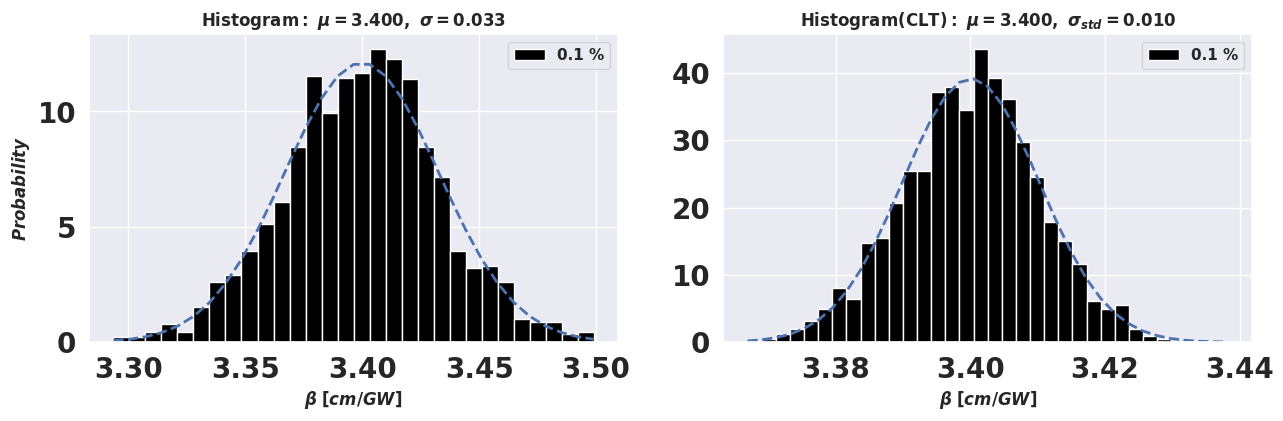

In [11]:
f=plt.figure(figsize=(15,4))
params=np.ones(12)
plt.subplot(121)
er_r=0.1
beta_hist=np.array(dist_betas2(2000,er_r,params))
print('Criterio de gaussianidad: ',confirm_gauss(beta_hist))
(mu, sigma) = norm.fit(beta_hist)
n, bins, patches =plt.hist(beta_hist,bins='fd',density=True,color='black',label=str(er_r)+' %')
y = norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'b--', linewidth=2)
plt.ylabel('$Probability$')
plt.xlabel(r'$\beta$ $[cm/GW]$')
plt.title(r'$\mathrm{Histogram:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)
plt.legend()


plt.subplot(122)
error=(round(np.std(beta_hist,ddof=1)/np.sqrt(len(beta_hist)),1))
beta_hist=central(beta_hist,10)
(mu, sigma) = norm.fit(beta_hist)
n, bins, patches =plt.hist(beta_hist,bins='fd',density=True,color='black',label=str(er_r)+' %')

# add a 'best fit' line
y = norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'b--', linewidth=2)

plt.xlabel(r'$\beta$ $[cm/GW]$')
plt.title(r'$\mathrm{Histogram(CLT):}\ \mu=%.3f,\ \sigma_{std}=%.3f$' %(mu, sigma))
plt.grid(True)
plt.legend()






# Perspectiva 2: Variación en todos los parametros.

In [12]:
beta_med=[]
beta_sig=[]
er_r=np.linspace(0.005,10,50) #Porcentaje de error
decis=[]

for j in er_r:
    
    beta_hist=np.array(dist_betas2(250,j,params))
    criterio=confirm_gauss(beta_hist)
    decis.append(criterio)

([<matplotlib.axis.XTick at 0x7ff6c9391d20>,
 [Text(0, 0, '0'),
  Text(2, 0, '2'),
  Text(4, 0, '4'),
  Text(6, 0, '6'),
  Text(8, 0, '8'),
  Text(10, 0, '10')])

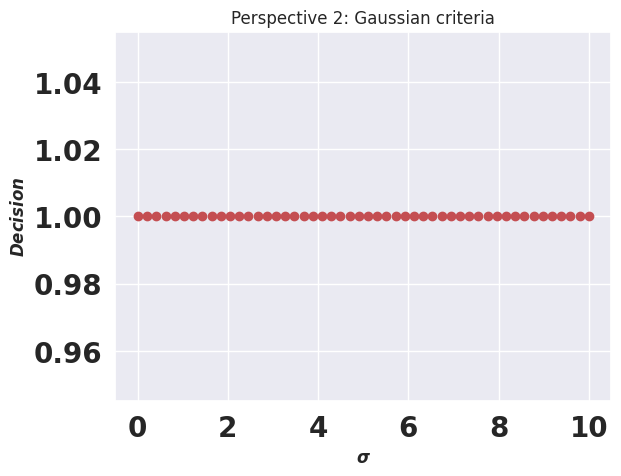

In [13]:
plt.plot(er_r,decis,'ro')
plt.xlabel('$\sigma$')
plt.ylabel('$Decision$')
plt.title('Perspective 2: Gaussian criteria')
plt.xticks([0,2,4,6,8,10],fontsize=20)

# Variación de a parametro:

In [14]:
results2=[]
er_r=np.linspace(0.005,10,50) #Porcentaje de error
params=np.diag(np.ones(12))

for i in range(0,12):
    
    final=[]

    
    for c,j in enumerate(er_r):

        beta_hist=np.array(dist_betas2(500,j,params[i,:]))
        criterio=confirm_gauss(beta_hist)
        final.append(criterio)
    
    results2.append(final)


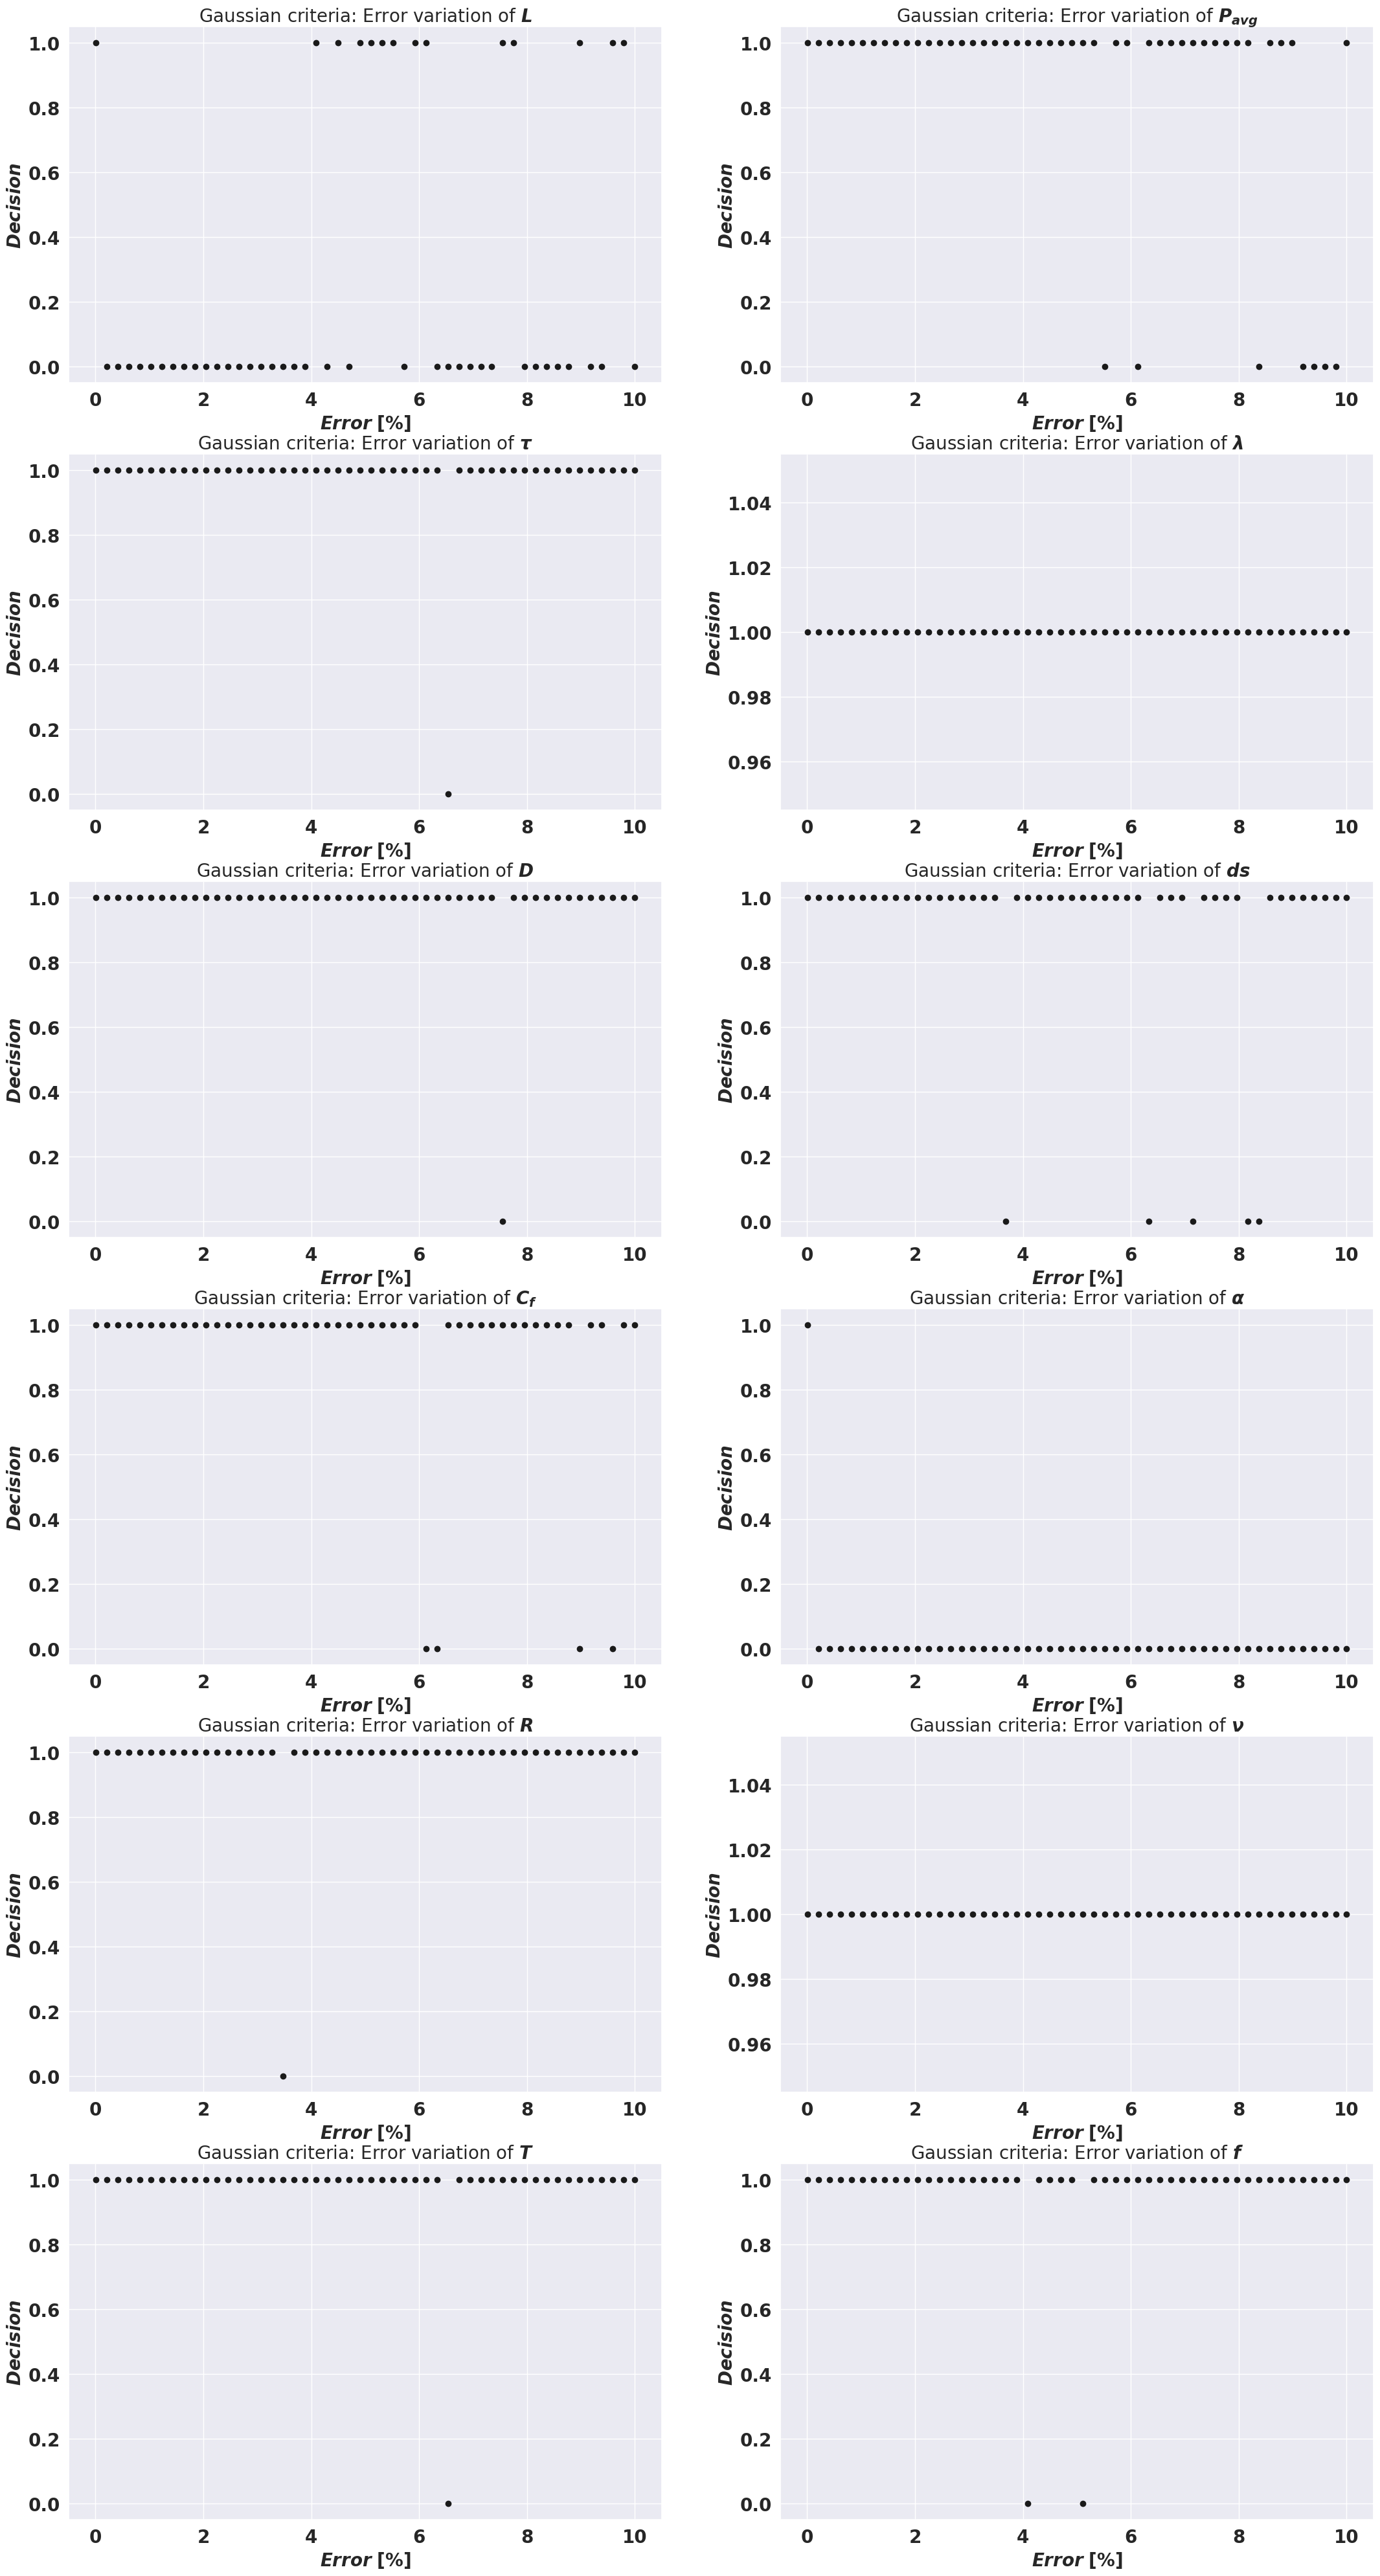

In [15]:
f=plt.figure(figsize=(26,50))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
titles=[r'$L$',r'$P_{avg}$',r'$\tau$',r'$\lambda$',r'$D$',r'$ds$',r'$C_{f}$',r'$\alpha$',r'$R$',r'$\nu$',r'$T$',r'$f$']
iters=1

for c,i in enumerate(results2):

    plt.subplot(6,2,iters)
    plt.plot(er_r,i,'ko')
    plt.xlabel('$Error$ $[\%]$',fontsize=20)
    plt.ylabel('$Decision$',fontsize=20)
    plt.xticks([0,2,4,6,8,10],fontsize=20)
    plt.title(r'Gaussian criteria: Error variation of '+titles[c],fontsize=20)
    iters+=1
 

    